In [ ]:
# Installiamo le librerie necessarie
!pip install kaggle
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git
!pip install lime
!pip install shap

# Configurazione per evitare warning
import warnings
warnings.filterwarnings('ignore')

# Importazioni necessarie
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import models

from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

# Verifica della GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Verifica della versione di CUDA
if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")

# Verifica che tutto sia installato correttamente
try:
    from pytorch_grad_cam import GradCAM
    print("GradCAM imported successfully")
except ImportError as e:
    print(f"Error importing GradCAM: {e}")

  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-9q6h20hs
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-9q6h20hs
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit a2a23f83916d1caa428c447890d7ed5870818341
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39156 sha256=3e067ac498e1840889b30ad56d9ac9aa37a01b6a35d906669a48c3dbe662c923
  Stored in directory: /tmp/pip-ephem-wheel-cache-44jl75xz/wheels/23/11/66/71a38b0c29ba4ec5f62105a2145278613855bc9c94eecf630d
Successfully built grad-cam
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 18.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=c23ae66cad152b5e

In [ ]:
# Configurazione Kaggle
# Carica il tuo file kaggle.json
from google.colab import files
files.upload()  # Carica qui il tuo file kaggle.json

# Configura le credenziali Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Scarica il dataset
!kaggle datasets download -d anujms/car-damage-detection
!unzip car-damage-detection.zip -d ./car_damage_data

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/anujms/car-damage-detection
License(s): unknown
 99% 122M/123M [00:07<00:00, 24.2MB/s]
100% 123M/123M [00:07<00:00, 16.5MB/s]
Archive:  car-damage-detection.zip
  inflating: ./car_damage_data/data1a/training/00-damage/0001.JPEG  
  inflating: ./car_damage_data/data1a/training/00-damage/0002.JPEG  
  inflating: ./car_damage_data/data1a/training/00-damage/0003.JPEG  
  inflating: ./car_damage_data/data1a/training/00-damage/0004.JPEG  
  inflating: ./car_damage_data/data1a/training/00-damage/0005.JPEG  
  inflating: ./car_damage_data/data1a/training/00-damage/0006.JPEG  
  inflating: ./car_damage_data/data1a/training/00-damage/0007.JPEG  
  inflating: ./car_damage_data/data1a/training/00-damage/0008.JPEG  
  inflating: ./car_damage_data/data1a/training/00-damage/0009.JPEG  
  inflating: ./car_damage_data/data1a/training/00-damage/0010.JPEG  
  inflating: ./car_damage_data/data1a/training/00-damage/0011.JPEG  
 

In [ ]:
class CarDamageDataset(Dataset):
    def __init__(self, root_dir, transform=None, split='train'):
        self.root_dir = root_dir
        self.transform = transform
        self.split = split
        self.damage_types = ['whole', 'damage']

        base_path = os.path.join(root_dir, 'data1a')

        # Determina quale cartella usare in base allo split
        if split in ['train', 'test']:
            data_folder = 'training'  # Useremo parte del training set come test
        elif split == 'val':
            data_folder = 'validation'
        else:
            raise ValueError(f"Split {split} non valido. Usa 'train', 'val', o 'test'")

        folder_path = os.path.join(base_path, data_folder)
        all_images = []

        # Raccogli tutte le immagini dal folder appropriato
        for damage_folder in ['00-damage', '01-whole']:
            damage_type = 'damage' if '00-damage' in damage_folder else 'whole'
            full_path = os.path.join(folder_path, damage_folder)

            if os.path.exists(full_path):
                for img_name in os.listdir(full_path):
                    if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                        all_images.append({
                            'image_path': os.path.join(full_path, img_name),
                            'label': damage_type
                        })

        # Converti in DataFrame
        self.df = pd.DataFrame(all_images)

        # Se è richiesto il test set, prendi il 20% del training set
        if split == 'test':
            _, self.df = train_test_split(self.df, test_size=0.2,
                                        stratify=self.df['label'],
                                        random_state=42)
        elif split == 'train':
            self.df, _ = train_test_split(self.df, test_size=0.2,
                                        stratify=self.df['label'],
                                        random_state=42)

        print(f"\nStatistiche per {split} split:")
        print(f"Numero totale di immagini: {len(self.df)}")
        print("Distribuzione delle classi:")
        print(self.df['label'].value_counts())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Errore nel caricamento dell'immagine {img_path}: {e}")
            raise

        label = self.damage_types.index(self.df.iloc[idx]['label'])

        if self.transform:
            image = self.transform(image)

        return image, label

# Definizione delle trasformazioni
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Creazione dei dataset
print("Creazione dei dataset...")

try:
    # Crea i dataset
    train_dataset = CarDamageDataset(root_dir='./car_damage_data',
                                    transform=train_transform,
                                    split='train')

    val_dataset = CarDamageDataset(root_dir='./car_damage_data',
                                  transform=val_transform,
                                  split='val')

    test_dataset = CarDamageDataset(root_dir='./car_damage_data',
                                   transform=val_transform,
                                   split='test')

    # Crea i data loader
    train_loader = DataLoader(train_dataset, batch_size=16,
                            shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=16,
                          shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=16,
                           shuffle=False, num_workers=2)

    print("\nInfo dataset:")
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")

except Exception as e:
    print(f"Errore nella creazione dei dataset: {e}")

Creazione dei dataset...

Statistiche per train split:
Numero totale di immagini: 1472
Distribuzione delle classi:
label
damage    736
whole     736
Name: count, dtype: int64

Statistiche per val split:
Numero totale di immagini: 460
Distribuzione delle classi:
label
damage    230
whole     230
Name: count, dtype: int64

Statistiche per test split:
Numero totale di immagini: 368
Distribuzione delle classi:
label
whole     184
damage    184
Name: count, dtype: int64

Info dataset:
Training samples: 1472
Validation samples: 460
Test samples: 368


In [ ]:

class DamageClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Utilizziamo EfficientNet come backbone
        self.model = models.efficientnet_b2(pretrained=True)

        # Modifichiamo l'ultimo layer
        num_ftrs = self.model.classifier[1].in_features
        self.model.classifier[1] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

# Classe per XAI aggiornata
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import matplotlib.pyplot as plt
import numpy as np

class XAIVisualizer:
    def __init__(self, model):
        self.model = model

        self.grad_cam = GradCAM(
            model=model,
            target_layers=[model.model.features[-1]]
        )

    def generate_cam(self, input_tensor, target_category):
        # Create target for GradCAM
        targets = [ClassifierOutputTarget(target_category)]

        # Generate CAM
        grayscale_cam = self.grad_cam(input_tensor=input_tensor,
                                    targets=targets)
        return grayscale_cam[0, :]

    def visualize_explanation(self, image, prediction, confidence, true_label=None):
        # Generate GradCAM
        device = next(self.model.parameters()).device
        cam = self.generate_cam(image.unsqueeze(0).to(device), prediction)

        # Convert tensor to numpy for visualization
        image_np = image.cpu().permute(1, 2, 0).numpy()

        # Denormalize the image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image_np = std * image_np + mean
        image_np = np.clip(image_np, 0, 1)

        # Create visualization
        plt.figure(figsize=(15, 5))

        # Original image
        plt.subplot(1, 3, 1)
        plt.imshow(image_np)
        plt.title('Original Image')
        plt.axis('off')

        # GradCAM heatmap
        plt.subplot(1, 3, 2)
        plt.imshow(cam, cmap='jet')
        plt.title('Attention Map')
        plt.axis('off')

        # Overlay
        plt.subplot(1, 3, 3)
        visualization = show_cam_on_image(image_np, cam)
        title = f'Overlay\nPrediction: {confidence:.1f}%'
        if true_label is not None:
            title += f'\nTrue: {true_label}'
        plt.imshow(visualization)
        plt.title(title)
        plt.axis('off')

        plt.tight_layout()
        plt.show()



# Creazione model e XAI visualizer
model = DamageClassifier(num_classes=len(train_dataset.damage_types))
for param in model.model.features.parameters():
    param.requires_grad = False
model = model.to(device)
xai_visualizer = XAIVisualizer(model)

# Creazione data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)


# Training history
train_losses = []
val_losses = []
train_accs = []
val_accs = []
best_val_acc = 0

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 118MB/s]


In [ ]:
# Training parameters
num_epochs = 8
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)

# Training history
train_losses = []
val_losses = []
train_accs = []
val_accs = []
best_val_acc = 0

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')

    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader, desc='Training')):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if batch_idx % 20 == 0:
            print(f'Batch: {batch_idx}, Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')

    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation phase
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc='Validation'):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    val_loss = running_loss / len(val_loader)
    val_acc = 100. * correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
        }, 'best_model.pth')
        print(f'Saved new best model with validation accuracy: {val_acc:.2f}%')

    # Update scheduler
    scheduler.step(val_loss)
    print("Training completato. Salvataggio del modello...")
# Salva solo i pesi del modello (state_dict)

torch.save(model.state_dict(), 'best_model_weights.pth')

print("Modello salvato come 'car_damage_model.pth'")


Epoch 1/8


Training:   0%|          | 0/92 [00:00<?, ?it/s]

Batch: 0, Loss: 0.6473, Acc: 56.25%
Batch: 20, Loss: 0.4414, Acc: 69.94%
Batch: 40, Loss: 0.4134, Acc: 75.00%
Batch: 60, Loss: 0.5501, Acc: 76.54%
Batch: 80, Loss: 0.4353, Acc: 78.55%


Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 1/8:
Train Loss: 0.4504, Train Acc: 79.55%
Val Loss: 0.3225, Val Acc: 88.04%
Saved new best model with validation accuracy: 88.04%
Training completato. Salvataggio del modello...

Epoch 2/8


Training:   0%|          | 0/92 [00:00<?, ?it/s]

Batch: 0, Loss: 0.4507, Acc: 81.25%
Batch: 20, Loss: 0.2375, Acc: 84.23%
Batch: 40, Loss: 0.3302, Acc: 85.21%
Batch: 60, Loss: 0.3739, Acc: 84.84%
Batch: 80, Loss: 0.1036, Acc: 85.42%


Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 2/8:
Train Loss: 0.3406, Train Acc: 85.33%
Val Loss: 0.2806, Val Acc: 89.35%
Saved new best model with validation accuracy: 89.35%
Training completato. Salvataggio del modello...

Epoch 3/8


Training:   0%|          | 0/92 [00:00<?, ?it/s]

Batch: 0, Loss: 0.1677, Acc: 100.00%
Batch: 20, Loss: 0.3636, Acc: 86.61%
Batch: 40, Loss: 0.6185, Acc: 85.98%
Batch: 60, Loss: 0.2166, Acc: 86.37%
Batch: 80, Loss: 0.2222, Acc: 86.73%


Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 3/8:
Train Loss: 0.3104, Train Acc: 87.23%
Val Loss: 0.2971, Val Acc: 86.96%
Training completato. Salvataggio del modello...

Epoch 4/8


Training:   0%|          | 0/92 [00:00<?, ?it/s]

Batch: 0, Loss: 0.1511, Acc: 100.00%
Batch: 20, Loss: 0.3389, Acc: 90.18%
Batch: 40, Loss: 0.2524, Acc: 89.79%
Batch: 60, Loss: 0.4799, Acc: 88.83%
Batch: 80, Loss: 0.5284, Acc: 88.89%


Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 4/8:
Train Loss: 0.2801, Train Acc: 89.27%
Val Loss: 0.2620, Val Acc: 89.35%
Training completato. Salvataggio del modello...

Epoch 5/8


Training:   0%|          | 0/92 [00:00<?, ?it/s]

Batch: 0, Loss: 0.2035, Acc: 93.75%
Batch: 20, Loss: 0.3479, Acc: 88.99%
Batch: 40, Loss: 0.2856, Acc: 88.87%
Batch: 60, Loss: 0.1866, Acc: 89.55%
Batch: 80, Loss: 0.2587, Acc: 88.73%


Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 5/8:
Train Loss: 0.2836, Train Acc: 88.79%
Val Loss: 0.2559, Val Acc: 89.35%
Training completato. Salvataggio del modello...

Epoch 6/8


Training:   0%|          | 0/92 [00:00<?, ?it/s]

Batch: 0, Loss: 0.4855, Acc: 75.00%
Batch: 20, Loss: 0.2826, Acc: 89.58%
Batch: 40, Loss: 0.2708, Acc: 88.87%
Batch: 60, Loss: 0.2805, Acc: 87.60%
Batch: 80, Loss: 0.2165, Acc: 88.27%


Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 6/8:
Train Loss: 0.2781, Train Acc: 88.45%
Val Loss: 0.2635, Val Acc: 89.57%
Saved new best model with validation accuracy: 89.57%
Training completato. Salvataggio del modello...

Epoch 7/8


Training:   0%|          | 0/92 [00:00<?, ?it/s]

Batch: 0, Loss: 0.2826, Acc: 81.25%
Batch: 20, Loss: 0.4325, Acc: 91.37%
Batch: 40, Loss: 0.4030, Acc: 90.09%
Batch: 60, Loss: 0.1296, Acc: 89.65%
Batch: 80, Loss: 0.2283, Acc: 90.51%


Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 7/8:
Train Loss: 0.2579, Train Acc: 89.95%
Val Loss: 0.2449, Val Acc: 90.00%
Saved new best model with validation accuracy: 90.00%
Training completato. Salvataggio del modello...

Epoch 8/8


Training:   0%|          | 0/92 [00:00<?, ?it/s]

Batch: 0, Loss: 0.6664, Acc: 75.00%
Batch: 20, Loss: 0.3084, Acc: 86.31%
Batch: 40, Loss: 0.5573, Acc: 87.96%
Batch: 60, Loss: 0.1058, Acc: 88.73%
Batch: 80, Loss: 0.1246, Acc: 88.97%


Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 8/8:
Train Loss: 0.2761, Train Acc: 88.93%
Val Loss: 0.2439, Val Acc: 90.43%
Saved new best model with validation accuracy: 90.43%
Training completato. Salvataggio del modello...
Modello salvato come 'car_damage_model.pth'


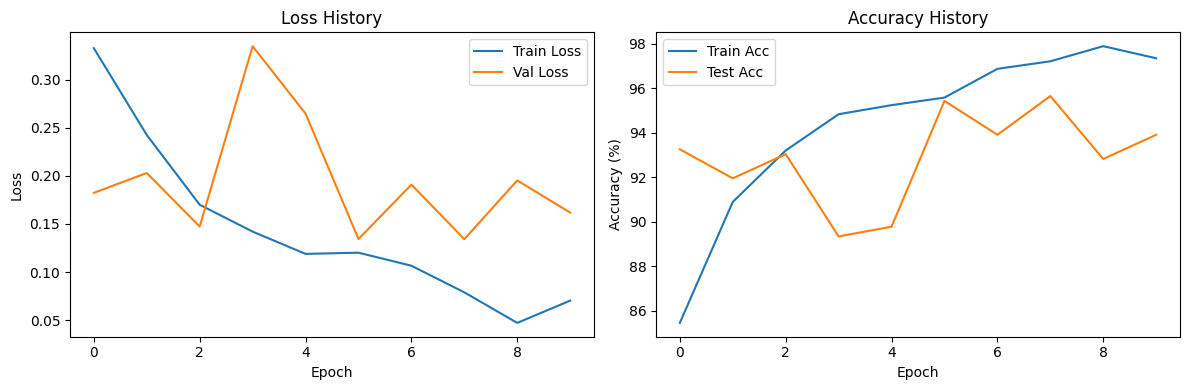

Visualizzazione predizioni con spiegazioni XAI:


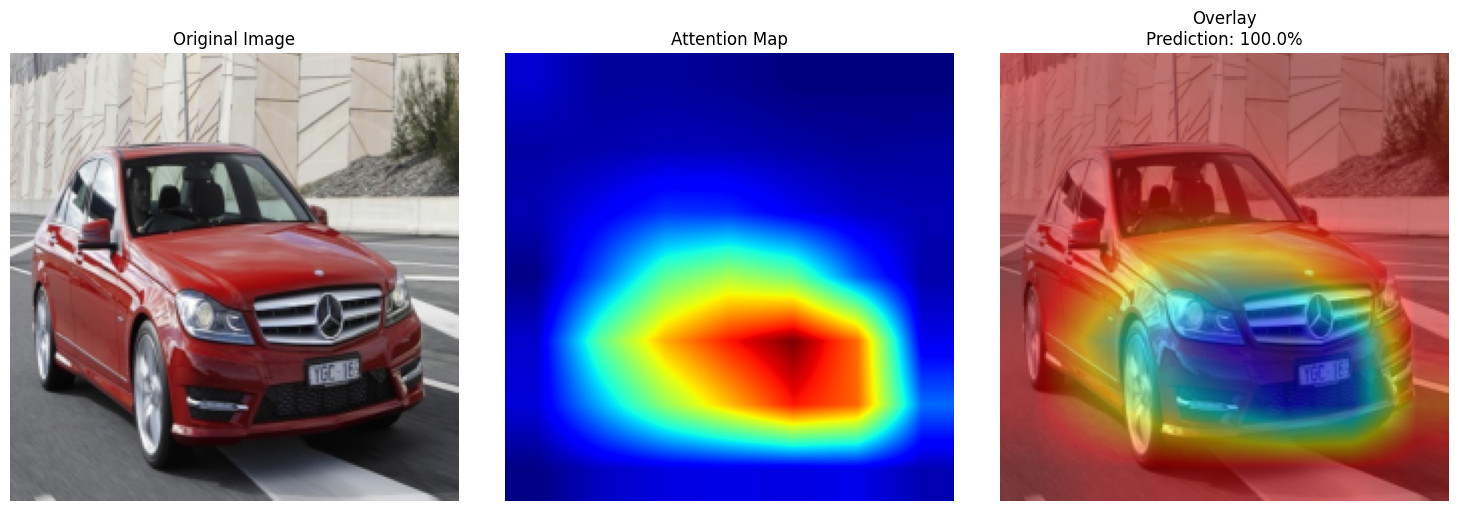

True label: whole
Predicted: whole (Confidence: 100.00%)
--------------------------------------------------


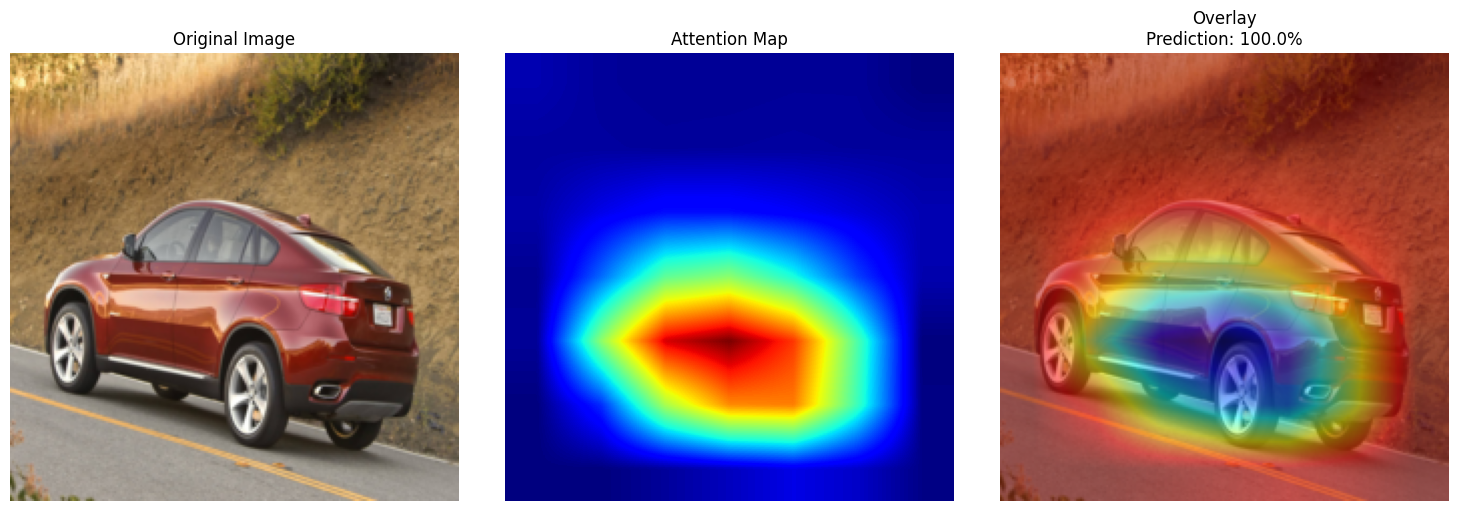

True label: whole
Predicted: whole (Confidence: 99.99%)
--------------------------------------------------


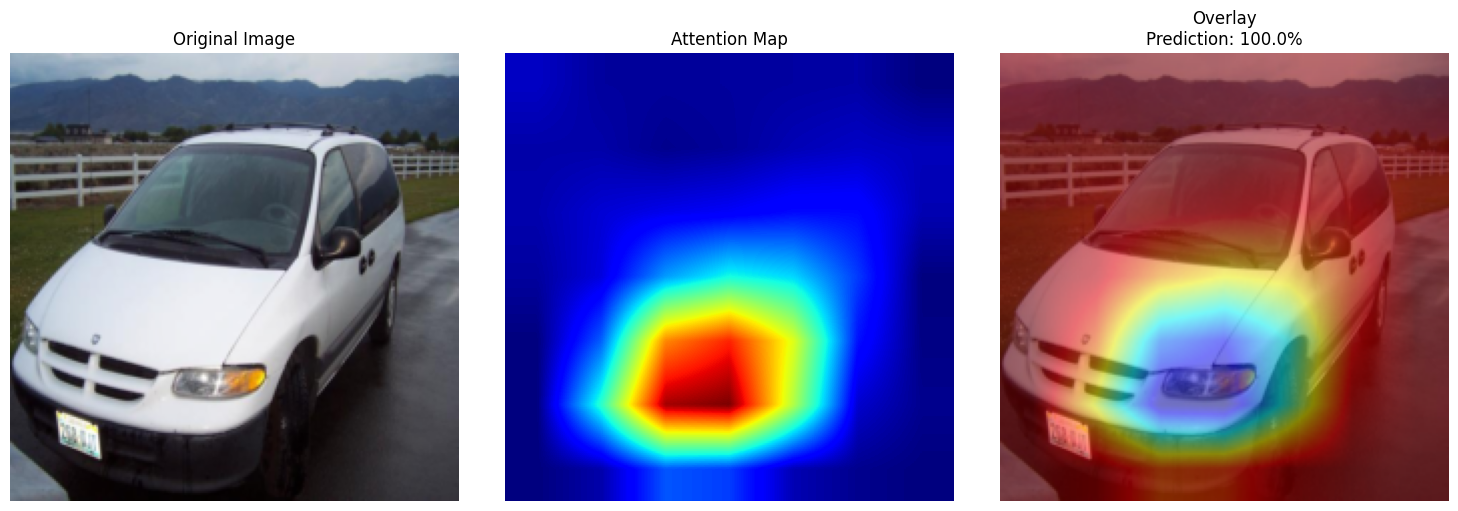

True label: whole
Predicted: whole (Confidence: 99.98%)
--------------------------------------------------


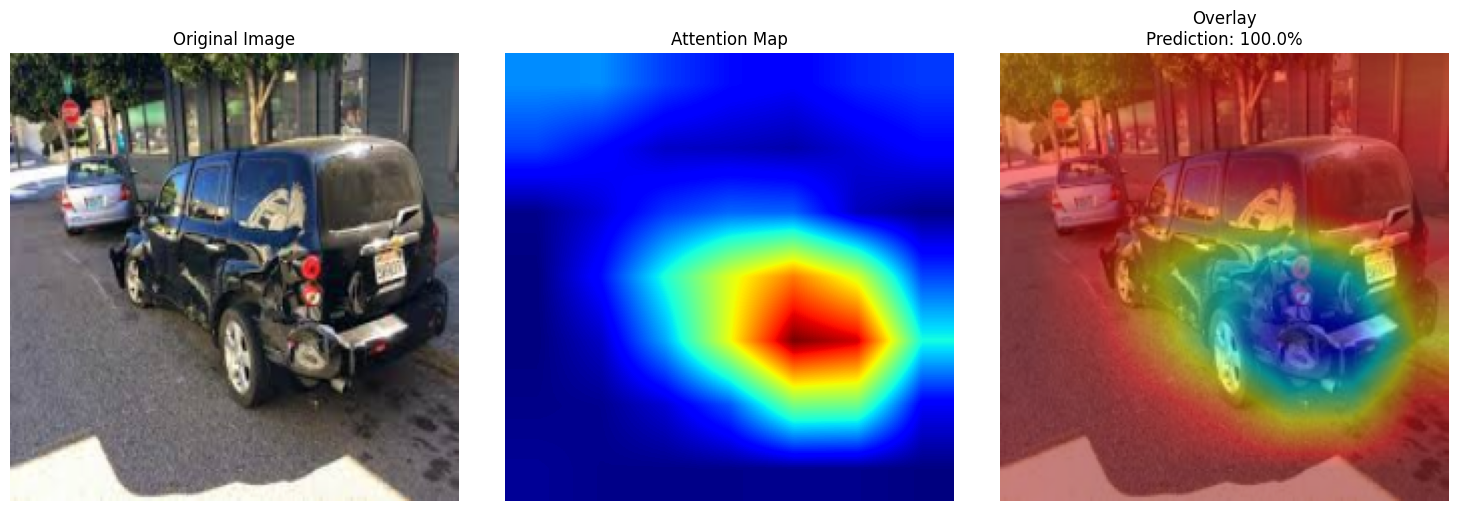

True label: damage
Predicted: damage (Confidence: 100.00%)
--------------------------------------------------


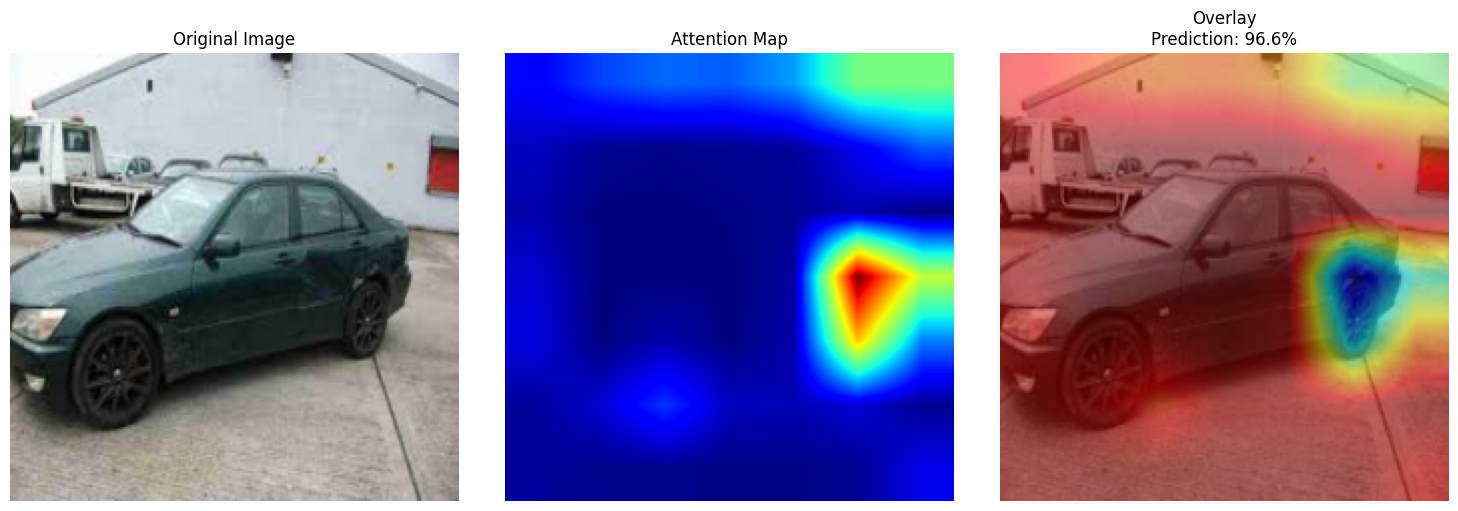

True label: damage
Predicted: damage (Confidence: 96.61%)
--------------------------------------------------


In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Test Acc')
plt.title('Accuracy History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Carica il miglior modello per le visualizzazioni XAI
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Visualizza alcune predizioni con XAI
def show_predictions_with_xai(model, dataset, xai_visualizer, num_samples=5):
    # Prendi alcuni campioni random
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    for idx in indices:
        image, true_label = dataset[idx]

        # Predizione
        with torch.no_grad():
            output = model(image.unsqueeze(0).to(device))
            prob = torch.nn.functional.softmax(output, dim=1)
            predicted_class = output.argmax(1).item()
            confidence = prob.max().item() * 100

        # Visualizza con XAI
        xai_visualizer.visualize_explanation(
            image,
            predicted_class,
            confidence
        )

        print(f'True label: {dataset.damage_types[true_label]}')
        print(f'Predicted: {dataset.damage_types[predicted_class]} (Confidence: {confidence:.2f}%)')
        print('-' * 50)

# Mostra alcune predizioni con spiegazioni
print("Visualizzazione predizioni con spiegazioni XAI:")
show_predictions_with_xai(model, test_dataset, xai_visualizer)





Valutazione del modello sul test set...

Confusion Matrix:
[[169  15]
 [  9 175]]


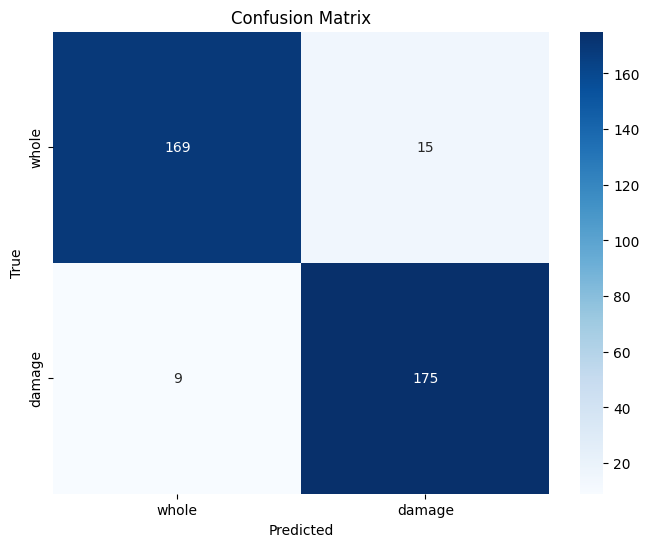


Classification Report:
              precision    recall  f1-score   support

       whole       0.95      0.92      0.93       184
      damage       0.92      0.95      0.94       184

    accuracy                           0.93       368
   macro avg       0.94      0.93      0.93       368
weighted avg       0.94      0.93      0.93       368


Metriche aggregate:
Accuracy : 0.9348
Precision: 0.9352
Recall   : 0.9348
F1-Score : 0.9348


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import torch
import numpy as np
import matplotlib.pyplot as plt

# ===========================
# Funzione per valutare il modello
# ===========================
def evaluate_model(model, test_loader, damage_types):
    model.eval()
    y_true = []
    y_pred = []

    # Itera sul test set per raccogliere le predizioni e i target reali
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calcolo della matrice di confusione
    cm = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    # Visualizza la matrice di confusione
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=damage_types, yticklabels=damage_types, cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Calcolo del report di classificazione
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=damage_types))

    # Ritorna il risultato per ulteriori analisi
    return cm, classification_report(y_true, y_pred, target_names=damage_types, output_dict=True)

# ===========================
# Valutazione del modello
# ===========================
print("Valutazione del modello sul test set...")
cm, report = evaluate_model(model, test_loader, train_dataset.damage_types)

# ===========================
# Metriche aggregate
# ===========================
# Stampa alcune metriche principali
accuracy = report['accuracy']
precision = np.mean([report[cls]['precision'] for cls in train_dataset.damage_types])
recall = np.mean([report[cls]['recall'] for cls in train_dataset.damage_types])
f1_score = np.mean([report[cls]['f1-score'] for cls in train_dataset.damage_types])

print("\nMetriche aggregate:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1_score:.4f}")


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import os
import pandas as pd
from sklearn.model_selection import train_test_split

class CarDamageDataset:
    def __init__(self, root_dir, split='train', img_size=(224, 224)):
        self.root_dir = root_dir
        self.split = split
        self.img_size = img_size
        self.damage_types = ['whole', 'damage']

        base_path = os.path.join(root_dir, 'data1a')

        # Determina quale cartella usare in base allo split
        if split in ['train', 'test']:
            data_folder = 'training'  # Useremo parte del training set come test
        elif split == 'val':
            data_folder = 'validation'
        else:
            raise ValueError(f"Split {split} non valido. Usa 'train', 'val', o 'test'")

        folder_path = os.path.join(base_path, data_folder)
        all_images = []

        # Raccogli tutte le immagini dal folder appropriato
        for damage_folder in ['00-damage', '01-whole']:
            damage_type = 'damage' if '00-damage' in damage_folder else 'whole'
            full_path = os.path.join(folder_path, damage_folder)

            if os.path.exists(full_path):
                for img_name in os.listdir(full_path):
                    if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                        all_images.append({
                            'image_path': os.path.join(full_path, img_name),
                            'label': damage_type
                        })

        # Converti in DataFrame
        self.df = pd.DataFrame(all_images)

        # Se è richiesto il test set, prendi il 20% del training set
        if split == 'test':
            _, self.df = train_test_split(self.df, test_size=0.2,
                                        stratify=self.df['label'],
                                        random_state=42)
        elif split == 'train':
            self.df, _ = train_test_split(self.df, test_size=0.2,
                                        stratify=self.df['label'],
                                        random_state=42)

        print(f"\nStatistiche per {split} split:")
        print(f"Numero totale di immagini: {len(self.df)}")
        print("Distribuzione delle classi:")
        print(self.df['label'].value_counts())

    def parse_function(self, filename, label):
        # Converte il tensore in stringa
        image_path = filename.numpy().decode('utf-8')

        # Legge e decodifica l'immagine
        image = tf.io.read_file(image_path)
        image = tf.io.decode_jpeg(image, channels=3)

        # Ridimensiona e normalizza
        image = tf.image.resize(image, self.img_size)
        image = tf.cast(image, tf.float32) / 255.0

        return image, label

    def tf_parse_function(self, filename, label):
      [image, label] = tf.py_function(
          self.parse_function,
          [filename, label],
          [tf.float32, tf.float32]  # This is correct
      )
      # Ensure the shapes and dtypes are set properly
      image.set_shape([self.img_size[0], self.img_size[1], 3])
      label.set_shape([len(self.damage_types)])

      # Explicitly cast the label to float32
      label = tf.cast(label, tf.float32)
      return image, label

    def create_dataset(self, batch_size=32, shuffle=True):
        # Prepara i paths e le labels
        image_paths = self.df['image_path'].values
        labels = [self.damage_types.index(label) for label in self.df['label']]
        labels = tf.keras.utils.to_categorical(labels, num_classes=len(self.damage_types))
        labels = tf.cast(labels, dtype=tf.float32)

        # Crea il dataset
        dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

        if shuffle:
            dataset = dataset.shuffle(buffer_size=len(self.df))

        # Applica la funzione di parsing
        dataset = dataset.map(
            self.tf_parse_function,
            num_parallel_calls=tf.data.AUTOTUNE
        )

        # Batch e prefetch
        return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

def create_data_loaders(root_dir='./car_damage_data', batch_size=32):
    # Crea i dataset
    train_data = CarDamageDataset(root_dir, split='train')
    val_data = CarDamageDataset(root_dir, split='val')
    test_data = CarDamageDataset(root_dir, split='test')

    # Crea i tf.data.Dataset
    train_ds = train_data.create_dataset(batch_size=batch_size, shuffle=True)
    val_ds = val_data.create_dataset(batch_size=batch_size, shuffle=False)
    test_ds = test_data.create_dataset(batch_size=batch_size, shuffle=False)

    return train_ds, val_ds, test_ds

In [ ]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import optimizers


#creiamo la CNN da zero
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Dropout dopo il primo blocco conv

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Dropout dopo il secondo blocco conv

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Dropout dopo il terzo blocco conv

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Dropout dopo il quarto blocco conv

    Flatten(),
    Dense(512, activation='relu'),
    Dense(2, activation='softmax')
])
train_ds, val_ds, test_ds = create_data_loaders(
    root_dir='./car_damage_data',
    batch_size=32
)

#train model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.001),
              metrics=['acc'])

#Addestra il modello
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15
)

model.save('car_damage_model.h5')

#test model on test_set
test_loss, test_acc = model.evaluate(test_ds)
print('test acc:', test_acc)
#print other other metrics




Statistiche per train split:
Numero totale di immagini: 1472
Distribuzione delle classi:
label
damage    736
whole     736
Name: count, dtype: int64

Statistiche per val split:
Numero totale di immagini: 460
Distribuzione delle classi:
label
damage    230
whole     230
Name: count, dtype: int64

Statistiche per test split:
Numero totale di immagini: 368
Distribuzione delle classi:
label
whole     184
damage    184
Name: count, dtype: int64
Epoch 1/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 195ms/step - acc: 0.5123 - loss: 0.9558 - val_acc: 0.5891 - val_loss: 0.6870
Epoch 2/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 17s 203ms/step - acc: 0.5768 - loss: 0.6574 - val_acc: 0.7261 - val_loss: 0.6000
Epoch 3/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - acc: 0.6895 - loss: 0.5713 - val_acc: 0.7348 - val_loss: 0.5326
Epoch 4/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 213ms/step - acc: 0.7505 - loss: 0.5200 - val_acc: 0.7370 - val_loss: 0.5106
Epoch 5/15
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 224ms/step - acc: 0.7614 - loss: 0.503

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - acc: 0.7834 - loss: 0.5555
test acc: 0.801630437374115


In [ ]:
from tensorflow.keras.models import load_model

model_keras = load_model('car_damage_model.h5',safe_mode=False)

model_keras.summary()
total_params = model.count_params()

print(f"Numero totale di parametri nel modello: {total_params}")


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_41 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_40 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_51 (Dropout)                 │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_41 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_52 (Dropout)                 │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_42 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_53 (Dropout)                 │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_43 (MaxPooling2D)      │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_54 (Dropout)                 │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 512)                 │       9,437,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,942,212 (37.93 MB)

 Trainable params: 9,942,210 (37.93 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Numero totale di parametri nel modello: 9942210


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import optimizers
from sklearn.metrics import confusion_matrix



# ===========================
# Definizione del modello
# ===========================
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Dropout dopo il primo blocco conv

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Dropout dopo il secondo blocco conv

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Dropout dopo il terzo blocco conv

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Dropout dopo il quarto blocco conv

    Flatten(),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(2, activation='softmax')
])

# ===========================
# Creazione dei dataset
# ===========================
train_ds, val_ds, test_ds = create_data_loaders(
    root_dir='./car_damage_data',  # aggiorna con la tua directory
    batch_size=32
)

# ===========================
# Compilazione del modello
# ===========================
# Aggiungiamo metriche extra: Precision, Recall, AUC
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.001),
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

# ===========================
# Addestramento del modello
# ===========================
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

# Salvataggio del modello
model.save('car_damage_model.h5')

# ===========================
# Valutazione su test set
# ===========================
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_ds)
print(f"Test Loss      : {test_loss}")
print(f"Test Accuracy  : {test_accuracy}")
print(f"Test Precision : {test_precision}")
print(f"Test Recall    : {test_recall}")
print(f"Test AUC       : {test_auc}")

# ===========================
# Confusion Matrix
# ===========================
y_true = []
y_pred = []

for images, labels in test_ds:
    # Predizioni
    preds = model.predict(images)
    # Convertiamo le predizioni in classi
    y_pred_batch = np.argmax(preds, axis=1)
    y_true_batch = np.argmax(labels.numpy(), axis=1)

    y_pred.extend(y_pred_batch)
    y_true.extend(y_true_batch)

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# ===========================
# Analisi delle metriche di addestramento e validazione
# ===========================
print("\nMetriche disponibili nello storico:")
print(history.history.keys())

# Se vuoi, puoi estrarre e stampare ad es.:
# print(history.history['accuracy'])
# print(history.history['val_accuracy'])
# print(history.history['precision'])
# print(history.history['val_precision'])
# etc.



Statistiche per train split:
Numero totale di immagini: 1472
Distribuzione delle classi:
label
damage    736
whole     736
Name: count, dtype: int64

Statistiche per val split:
Numero totale di immagini: 460
Distribuzione delle classi:
label
damage    230
whole     230
Name: count, dtype: int64

Statistiche per test split:
Numero totale di immagini: 368
Distribuzione delle classi:
label
whole     184
damage    184
Name: count, dtype: int64
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 16s 213ms/step - accuracy: 0.5242 - auc: 0.5165 - loss: 1.0065 - precision: 0.5242 - recall: 0.5242 - val_accuracy: 0.5326 - val_auc: 0.5677 - val_loss: 0.6910 - val_precision: 0.5326 - val_recall: 0.5326
Epoch 2/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 0.5480 - auc: 0.5830 - loss: 0.6775 - precision: 0.5480 - recall: 0.5480 - val_accuracy: 0.5761 - val_auc: 0.6257 - val_loss: 0.6736 - val_precision: 0.5761 - val_recall: 0.5761
Epoch 3/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 201ms/step - accuracy: 0.6391 - auc: 0.6971 - loss: 0.6419 - precision: 0.6391 - recall: 0.6391 - val_accuracy: 0.6717 - val_auc: 0.7651 - val_loss: 0.5669 - val_precision: 0.6717 - val_recall: 0.6717
Epoch 4/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 204ms/step - accuracy: 0.7049 - auc: 0.7793 - loss: 0.5624 - precision: 0.7049 - recall: 0.7049 - val_accuracy: 0.7239 - val_auc: 0.7845 - val_loss: 0.5570 - val_precision: 0.7239 - val_recall: 0.7239
Epoch 5/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 2

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 264ms/step - accuracy: 0.6984 - auc: 0.7821 - loss: 0.5557 - precision: 0.6984 - recall: 0.6984
Test Loss      : 0.5271276831626892
Test Accuracy  : 0.7255434989929199
Test Precision : 0.7255434989929199
Test Recall    : 0.7255434989929199
Test AUC       : 0.812957763671875
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
Confusion Matrix:
[[ 95  89]
 [ 12 172]]

Metriche disponibili nello storico:
dict_keys(['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall'])


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc, f1_score, matthews_corrcoef, balanced_accuracy_score

# Supponiamo che `y_true` (etichette vere) e `y_pred` (etichette predette) siano già disponibili
# y_pred_proba è opzionale se il modello fornisce probabilità (es. softmax/sigmoid)
# y_true = [...]  # Riempi con le etichette vere
# y_pred = [...]  # Riempi con le etichette predette
# y_pred_proba = [...]  # Probabilità delle classi (opzionale)

# Classi del dataset
class_names = ['damage', 'whole']

# =====================
# Confusion Matrix
# =====================
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# =====================
# Normalized Confusion Matrix
# =====================
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# =====================
# Classification Report
# =====================
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", report)

# =====================
# Precision-Recall Curve
# =====================
if 'y_pred_proba' in locals():
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba[:, 1])

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid()
    plt.show()

# =====================
# ROC Curve
# =====================
if 'y_pred_proba' in locals():
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()
    plt.show()

# =====================
# F1 Score
# =====================
f1_weighted = f1_score(y_true, y_pred, average='weighted')
print(f"F1 Score (Weighted): {f1_weighted:.2f}")

f1_per_class = f1_score(y_true, y_pred, average=None)
print("F1 Score per classe:", dict(zip(class_names, f1_per_class)))

# =====================
# Matthews Correlation Coefficient (MCC)
# =====================
mcc = matthews_corrcoef(y_true, y_pred)
print(f"Matthews Correlation Coefficient: {mcc:.2f}")

# =====================
# Balanced Accuracy
# =====================
balanced_acc = balanced_accuracy_score(y_true, y_pred)
print(f"Balanced Accuracy: {balanced_acc:.2f}")

# =====================
# Metriche Storiche (opzionale)
# =====================
# Se hai un oggetto `history` dal modello, puoi tracciare le metriche nel tempo
if 'history' in locals():
    train_losses = history.history['loss']
    val_losses = history.history['val_loss']
    train_accs = history.history['accuracy']
    val_accs = history.history['val_accuracy']

    plt.figure(figsize=(12, 6))

    # Plot della Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot dell'Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title('Accuracy History')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
